<a href="https://colab.research.google.com/github/sleepless-se/Colab/blob/master/open_cv_remove_background.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageChops
import numpy as np

# # # # # #
# Pillow  #
# # # # # #

def crop_image(path:str)->Image:
  image = Image.open(path)
  # getpixel(0, 0) で左上の色を取得し、背景色のみの画像を作成する
  bgc = image.getpixel((0, 0))
  print('bgc',bgc)
  bg = Image.new(image.mode, image.size,bgc)

  # 背景色画像と元画像の差分を取得
  diff = ImageChops.difference(image, bg)
  #diff.show()
  diff = ImageChops.add(diff, diff, 2.0, -100)
  #diff.show()
  # 黒背景の境界Boxを取り出す
  bbox = diff.getbbox()
  # 元画像を切り出す
  cropped = image.crop(bbox)
  cropped.save('cropped_edge.jpg')
  cropped = image.crop(bbox)
  return cropped


def triple_images(imgs,size):
  x,y = 0,0

  # make background
  bgc = imgs[1].getpixel((0,0))
  bg = Image.new('RGB',(img_size,img_size),bgc)

  # image 1
  imgs[0].thumbnail((img_size,img_size))
  print('imgs[0]',imgs[0].size)
  bg.paste( imgs[0],(x,y) ) # image 1

  img_space = img_size - np.array(imgs[0].size).min()
  print('img_space',img_space)
  imgs[1].thumbnail((img_space,img_space))

  if imgs[0].size[0] != img_size: x = imgs[0].size[0] 
  if imgs[0].size[1] != img_size: y = imgs[0].size[1] 


  print('1:x,y',x,y)
  bg.paste(imgs[1],(x,y)) # image 2

  # image 2

  print('imgs[1]',imgs[1].size)

  if x == 0: x = imgs[1].size[0]
  if y == 0: y = imgs[1].size[1]
  print('2:x,y',x,y)

  sx = img_size - x
  sy = img_size - y

  print('xs,xy',sx,sy)

  imgs[2].thumbnail((sx,sy))
  bg.paste(imgs[2],(x,y)) # image 3

  return bg

bgc (255, 255, 255)
bgc (255, 255, 255)
bgc (255, 255, 255)
imgs[0] (302, 500)
img_space 198
1:x,y 302 0
imgs[1] (198, 86)
2:x,y 302 86
xs,xy 198 414


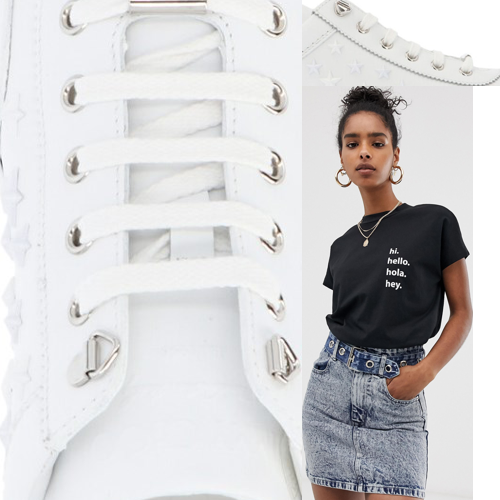

In [13]:

img_paths = ['/content/12030065/a03.jpg','/content/12030065/a02.jpg','/content/12030065/a04.jpg']
img_paths = ['/content/8934106/a02.jpg','/content/8934106/a01.jpg','/content/8934106/a03.jpg']
img_paths = ['/content/a3.jpg','/content/a1.jpg','/content/a01.jpg']
# img_paths = ['/content/11004955/a04.jpg','/content/11004955/a02.jpg','/content/11004955/a03.jpg']
# img_paths = ['/content/11006540/a03.jpg','/content/11006540/a04.jpg','/content/11006540/a01.jpg']
# img_paths = ['/content/11004770/a01.jpg','/content/11004770/a04.jpg','/content/11004770/a03.jpg']
# img_paths = ['/content/10990068/a03.jpg','/content/10990068/a02.jpg','/content/10990068/a04.jpg']
# img_paths = ['/content/10990068/a01.jpg','/content/10990068/a02.jpg','/content/10990068/a03.jpg','/content/10990068/a04.jpg']
imgs = [crop_image(path) for path in img_paths]
img_size = 500
triple_images(imgs,img_size)


In [0]:
!unzip small_sample.zip

In [0]:
!unzip shoes_sample.zip